### This notebook contains the implementation of Logistic Regression, Simple CNN, LeNet, and AlexNet. Please refer to vgg_tensorflow.ipynb and vgg_image_prediction.ipynb for implementation of VGG16.

In [ ]:
!pip install mxnet==1.4.0
!pip install tensorflow

Resizing the data

In [1]:
import os
import shutil
import random

TRAIN_DATA_DIR = 'intel_data/seg_train'
TEST_DATA_DIR = 'intel_data/seg_test'
REDUCED_TRAIN_DATA_DIR = 'intel_data/reduced_seg_train_new'
REDUCED_TEST_DATA_DIR = 'intel_data/reduced_seg_test_new'

DATA_RATIO = 0.2 

os.makedirs(REDUCED_TRAIN_DATA_DIR, exist_ok=True)
os.makedirs(REDUCED_TEST_DATA_DIR, exist_ok=True)

def reduce_dataset(input_dir, output_dir):
    for class_name in os.listdir(input_dir):
        class_dir = os.path.join(input_dir, class_name)
        output_class_dir = os.path.join(output_dir, class_name)
        os.makedirs(output_class_dir, exist_ok=True)
        
        images = os.listdir(class_dir)
        
        num_images_to_keep = int(len(images) * DATA_RATIO)
        
        selected_images = random.sample(images, num_images_to_keep)
        
        for image in selected_images:
            src_path = os.path.join(class_dir, image)
            dst_path = os.path.join(output_class_dir, image)
            shutil.copy(src_path, dst_path)

reduce_dataset(TRAIN_DATA_DIR, REDUCED_TRAIN_DATA_DIR)
reduce_dataset(TEST_DATA_DIR, REDUCED_TEST_DATA_DIR)

print("Reduced datasets created successfully.")


Reduced datasets created successfully.


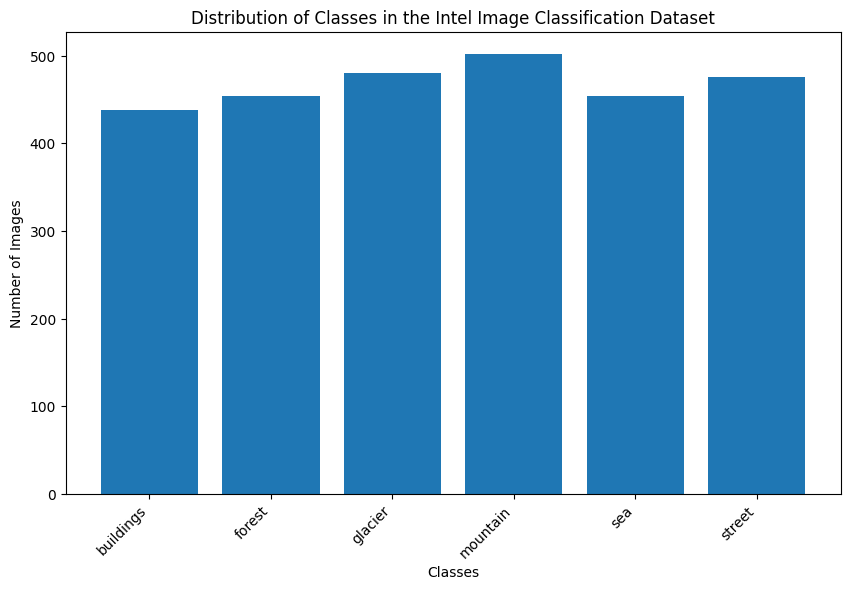

In [3]:
import os
import matplotlib.pyplot as plt

# Path to the directory containing the Intel Image Classification dataset
DATA_DIR = 'intel_data/reduced_seg_train_new'

# Function to count the number of images in each class
def count_images_per_class(directory):
    class_counts = {}
    for root, dirs, files in os.walk(directory):
        for dir_name in dirs:
            class_counts[dir_name] = len(os.listdir(os.path.join(root, dir_name)))
    return class_counts

# Get the class counts
class_counts = count_images_per_class(DATA_DIR)

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in the Intel Image Classification Dataset')
plt.xticks(rotation=45, ha='right')
plt.show()


### Simple CNN

MXNet

Epoch 1. Test Loss: 0.9983900707019003, Test Accuracy: 0.6204013377926422, Epoch Time: 358.6709363460541
Epoch 2. Test Loss: 0.9239551534778193, Test Accuracy: 0.6270903010033445, Epoch Time: 387.3693926334381
Epoch 3. Test Loss: 0.8883152431563327, Test Accuracy: 0.68561872909699, Epoch Time: 166.31277894973755


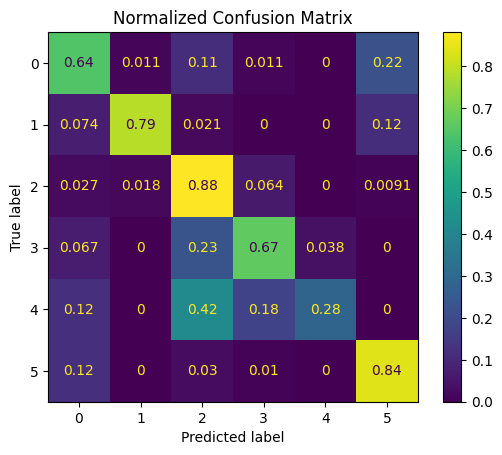

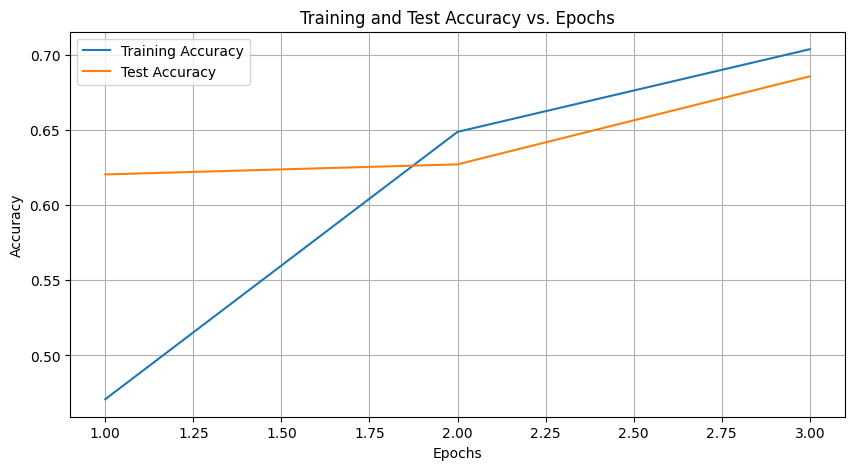

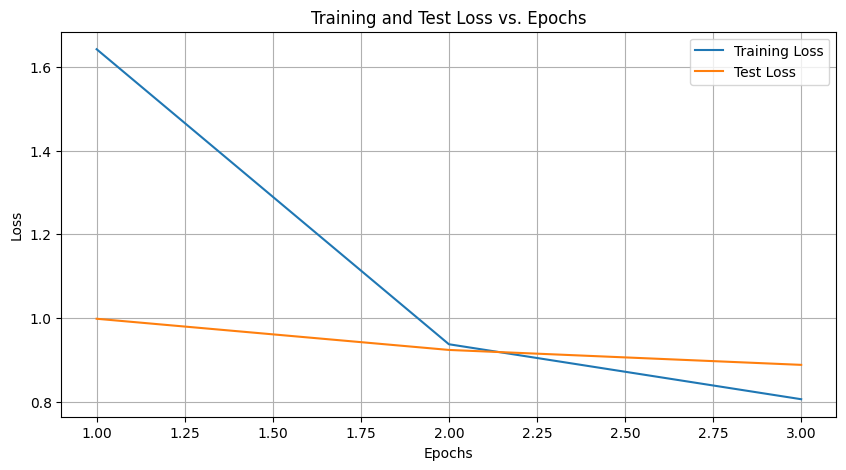

Total Training Time: 912.3531079292297 seconds
Total Testing Time: 912.3531079292297 seconds
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.64      0.61        87
           1       0.96      0.79      0.87        94
           2       0.54      0.88      0.67       110
           3       0.72      0.67      0.69       105
           4       0.88      0.28      0.43       102
           5       0.73      0.84      0.78       100

    accuracy                           0.69       598
   macro avg       0.74      0.68      0.67       598
weighted avg       0.73      0.69      0.67       598



In [14]:
import mxnet as mx
from mxnet.gluon.data.vision import ImageFolderDataset
from mxnet.gluon.data import DataLoader
from mxnet.gluon import nn
from mxnet import autograd
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

TRAIN_DATA_DIR = 'intel_data/reduced_seg_train_new'
TEST_DATA_DIR = 'intel_data/reduced_seg_test_new'

train_transform = mx.gluon.data.vision.transforms.Compose([
    mx.gluon.data.vision.transforms.Resize(224),
    #mx.gluon.data.vision.transforms.RandomFlipLeftRight(),
    #mx.gluon.data.vision.transforms.RandomColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    mx.gluon.data.vision.transforms.ToTensor(),
    mx.gluon.data.vision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = mx.gluon.data.vision.transforms.Compose([
    mx.gluon.data.vision.transforms.Resize(224),
    mx.gluon.data.vision.transforms.ToTensor(),
    mx.gluon.data.vision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load data
train_data = DataLoader(
    ImageFolderDataset(root=TRAIN_DATA_DIR).transform_first(train_transform),
    batch_size=32, shuffle=True, num_workers=4, last_batch='discard')

test_data = DataLoader(
    ImageFolderDataset(root=TEST_DATA_DIR).transform_first(test_transform),
    batch_size=32, shuffle=False, num_workers=4)

# CNN architecture
class CNN(mx.gluon.Block):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        with self.name_scope():
            self.conv1 = nn.Conv2D(channels=16, kernel_size=3, padding=1, activation='relu')
            self.pool1 = nn.MaxPool2D(pool_size=2)
            self.conv2 = nn.Conv2D(channels=32, kernel_size=3, padding=1, activation='relu')
            self.pool2 = nn.MaxPool2D(pool_size=2)
            self.conv3 = nn.Conv2D(channels=64, kernel_size=3, padding=1, activation='relu')
            self.pool3 = nn.MaxPool2D(pool_size=2)
            self.flatten = nn.Flatten()
            self.dense1 = nn.Dense(128, activation='relu')
            self.dense2 = nn.Dense(num_classes)

    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.pool3(self.conv3(x))
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

# Extract classes from the dataset
classes = set()
for _, label in train_data._dataset:
    classes.add(label)
num_classes = len(classes)

# Instantiate the model
model = CNN(num_classes)
model.initialize(mx.init.Xavier())

loss_fn = mx.gluon.loss.SoftmaxCrossEntropyLoss()
optimizer = mx.gluon.Trainer(model.collect_params(), 'adam')

epochs = 3

# Lists to store training and test accuracies, losses, and computational times
train_accuracy_history = []
test_accuracy_history = []
train_loss_history = []
test_loss_history = []
training_times = []
testing_times = []
total_training_time = 0

for epoch in range(epochs):
    start_time_training = time.time()
    
    # Training loop
    train_loss = 0.
    correct_train_preds = 0
    total_train_samples = 0
    for data, label in train_data:
        with autograd.record():
            output = model(data)
            loss = loss_fn(output, label)
        loss.backward()
        optimizer.step(data.shape[0])
        train_loss += loss.mean().asscalar()
        preds_train = mx.nd.argmax(output, axis=1).asnumpy()
        label_train = label.asnumpy()
        correct_train_preds += (preds_train == label_train).sum()
        total_train_samples += data.shape[0]
    
    # Compute training accuracy and average training loss
    train_accuracy = correct_train_preds / total_train_samples
    avg_train_loss = train_loss / len(train_data)
    train_accuracy_history.append(train_accuracy)
    train_loss_history.append(avg_train_loss)

    end_time_training = time.time()
    epoch_training_time = end_time_training - start_time_training
    total_training_time += epoch_training_time
    
    # Testing loop
    test_loss = 0.
    correct_test_preds = 0
    total_test_samples = 0
    for data, label in test_data:
        output = model(data)
        loss = loss_fn(output, label)
        test_loss += loss.mean().asscalar()
        preds_test = mx.nd.argmax(output, axis=1).asnumpy()
        label_test = label.asnumpy()
        correct_test_preds += (preds_test == label_test).sum()
        total_test_samples += data.shape[0]
    
    # Compute test accuracy and average test loss
    test_accuracy = correct_test_preds / total_test_samples
    avg_test_loss = test_loss / len(test_data)
    test_accuracy_history.append(test_accuracy)
    test_loss_history.append(avg_test_loss)
    
    end_time = time.time()
    epoch_time = end_time - start_time_training
    training_times.append(epoch_time)
    
    print(f"Epoch {epoch + 1}. Test Loss: {avg_test_loss}, Test Accuracy: {test_accuracy}, Epoch Time: {epoch_time}")
    
    # Record testing time
    testing_times.append(epoch_time)

# Calculate confusion matrix
true_labels = []
predicted_labels = []
for data, label in test_data:
    output = model(data)
    preds = mx.nd.argmax(output, axis=1).asnumpy()
    true_labels.extend(label.asnumpy())
    predicted_labels.extend(preds)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Normalize confusion matrix
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Display normalized confusion matrix
disp = ConfusionMatrixDisplay(normalized_conf_matrix)
disp.plot()
plt.title('Normalized Confusion Matrix')
plt.show()

# Generate line graphs for training accuracy and test accuracy vs. epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracy_history, label='Training Accuracy')
plt.plot(range(1, epochs + 1), test_accuracy_history, label='Test Accuracy')
plt.title('Training and Test Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Generate line graphs for training loss and test loss vs. epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, epochs + 1), test_loss_history, label='Test Loss')
plt.title('Training and Test Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Print total training and testing times
print(f"Total Training Time: {sum(training_times)} seconds")
print(f"Total Testing Time: {sum(testing_times)} seconds")

# Calculate and print classification report
classification_rep = classification_report(true_labels, predicted_labels)
print("Classification Report:\n", classification_rep)


Tensorflow

Found 2246 images belonging to 6 classes.
Found 598 images belonging to 6 classes.


C:\Users\yashi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
C:\Users\yashi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


71/71 ━━━━━━━━━━━━━━━━━━━━ 32s 394ms/step - accuracy: 0.2866 - loss: 1.8689
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5180 - loss: 1.1284
Epoch 1. Test Loss: 1.120950698852539, Test Accuracy: 0.54347825050354, Epoch Time: 32.488126277923584
71/71 ━━━━━━━━━━━━━━━━━━━━ 30s 394ms/step - accuracy: 0.5445 - loss: 1.1797
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5886 - loss: 1.0472
Epoch 2. Test Loss: 0.9928821325302124, Test Accuracy: 0.6137123703956604, Epoch Time: 30.676262378692627
71/71 ━━━━━━━━━━━━━━━━━━━━ 31s 398ms/step - accuracy: 0.5858 - loss: 1.0678
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6265 - loss: 0.9163
Epoch 3. Test Loss: 0.8956562280654907, Test Accuracy: 0.6538461446762085, Epoch Time: 31.058574199676514
71/71 ━━━━━━━━━━━━━━━━━━━━ 31s 400ms/step - accuracy: 0.6214 - loss: 0.9626
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6425 - loss: 0.8514
Epoch 4. Test Loss: 0.8442146182060242, Test Accuracy: 0.6806020140647888, Epoch Time

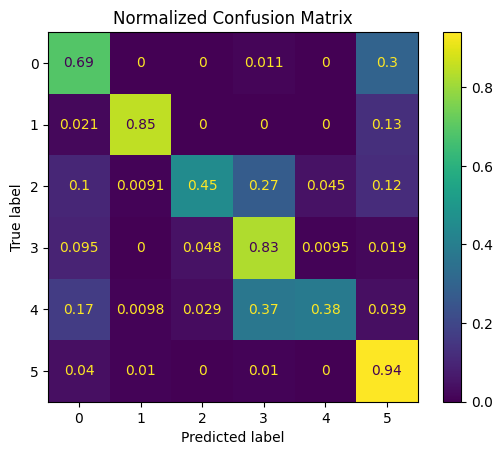

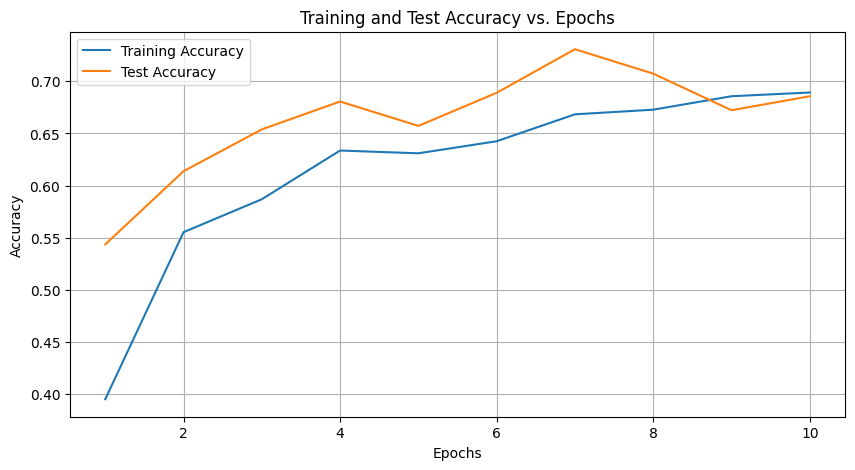

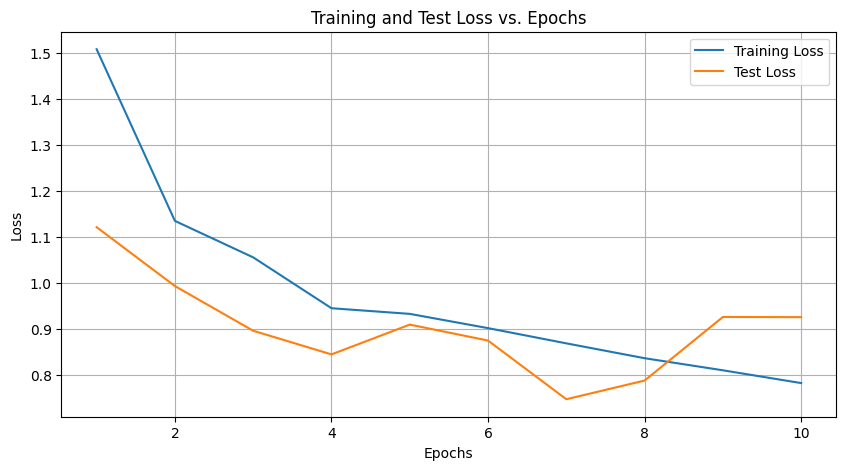

Total Training Time: 311.1783854961395 seconds
Total Testing Time: 10.686820983886719 seconds


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

TRAIN_DATA_DIR = 'intel_data/reduced_seg_train_new'
TEST_DATA_DIR = 'intel_data/reduced_seg_test_new'

# Define data generators with augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# CNN architecture
model = models.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Lists to store training and test accuracies, losses, and computational times
train_accuracy_history = []
test_accuracy_history = []
train_loss_history = []
test_loss_history = []
training_times = []
testing_times = []

# Train the model
epochs = 10
for epoch in range(epochs):
    start_time = time.time()
    history = model.fit(train_generator, epochs=1)
    end_time = time.time()
    epoch_time = end_time - start_time
    training_times.append(epoch_time)
    
    # Store training accuracy and loss
    train_accuracy_history.append(history.history['accuracy'][0])
    train_loss_history.append(history.history['loss'][0])
    
    # Evaluate the model on test data
    start_time = time.time()
    test_loss, test_accuracy = model.evaluate(test_generator)
    end_time = time.time()
    testing_times.append(end_time - start_time)
    
    # Store test accuracy and loss
    test_accuracy_history.append(test_accuracy)
    test_loss_history.append(test_loss)
    
    print(f"Epoch {epoch + 1}. Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Epoch Time: {epoch_time}")

# Extract true labels and predicted labels for classification report
true_labels = []
predicted_labels = []
for i in range(len(test_generator)):
    images, labels = test_generator[i]
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(np.argmax(labels, axis=1))

# Calculate and print classification report
classification_rep = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", classification_rep)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Normalize confusion matrix
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Display normalized confusion matrix
disp = ConfusionMatrixDisplay(normalized_conf_matrix)
disp.plot()
plt.title('Normalized Confusion Matrix')
plt.show()

# Generate line graphs for training accuracy and test accuracy vs. epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracy_history, label='Training Accuracy')
plt.plot(range(1, epochs + 1), test_accuracy_history, label='Test Accuracy')
plt.title('Training and Test Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Generate line graphs for training loss and test loss vs. epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, epochs + 1), test_loss_history, label='Test Loss')
plt.title('Training and Test Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Print total training and testing times
print(f"Total Training Time: {sum(training_times)} seconds")
print(f"Total Testing Time: {sum(testing_times)} seconds")


In [3]:
from scipy import stats

# Test Accuracy data for MXNet and TensorFlow
mxnet_test_accuracy = [0.6204, 0.6271, 0.6856]
tensorflow_test_accuracy = [0.5435, 0.6137, 0.6538, 0.6806, 0.6572, 0.6890, 0.7308, 0.7074]

# Test Loss data for MXNet and TensorFlow
mxnet_test_loss = [0.9984, 0.9240, 0.8883]
tensorflow_test_loss = [1.1210, 0.9929, 0.8957, 0.8442, 0.9091, 0.8743, 0.7467, 0.7873]

# Perform two-sample t-tests for Test Accuracy and Test Loss
accuracy_t_stat, accuracy_p_value = stats.ttest_ind(mxnet_test_accuracy, tensorflow_test_accuracy)
loss_t_stat, loss_p_value = stats.ttest_ind(mxnet_test_loss, tensorflow_test_loss)

# Output the results
print("Two-Sample t-test Results:")
print("Test Accuracy:")
print("  t-statistic:", accuracy_t_stat)
print("  p-value:", accuracy_p_value)
if accuracy_p_value < 0.05:
    print("  Reject the null hypothesis. There is a significant difference in Test Accuracy between MXNet and TensorFlow.")
else:
    print("  Fail to reject the null hypothesis. There is no significant difference in Test Accuracy between MXNet and TensorFlow.")

print("\nTest Loss:")
print("  t-statistic:", loss_t_stat)
print("  p-value:", loss_p_value)
if loss_p_value < 0.05:
    print("  Reject the null hypothesis. There is a significant difference in Test Loss between MXNet and TensorFlow.")
else:
    print("  Fail to reject the null hypothesis. There is no significant difference in Test Loss between MXNet and TensorFlow.")


Two-Sample t-test Results:
Test Accuracy:
  t-statistic: -0.4091953294197546
  p-value: 0.6919629268084353
  Fail to reject the null hypothesis. There is no significant difference in Test Accuracy between MXNet and TensorFlow.

Test Loss:
  t-statistic: 0.5571588453453927
  p-value: 0.5910035238933573
  Fail to reject the null hypothesis. There is no significant difference in Test Loss between MXNet and TensorFlow.


### Logistic Regression

MXNet

Test Accuracy: 0.362876254180602
Classification Report:
               precision    recall  f1-score   support

   buildings       0.27      0.25      0.26        87
      forest       0.64      0.57      0.61        94
     glacier       0.36      0.34      0.35       110
    mountain       0.32      0.46      0.38       105
         sea       0.17      0.17      0.17       102
      street       0.49      0.39      0.43       100

    accuracy                           0.36       598
   macro avg       0.37      0.36      0.37       598
weighted avg       0.37      0.36      0.36       598



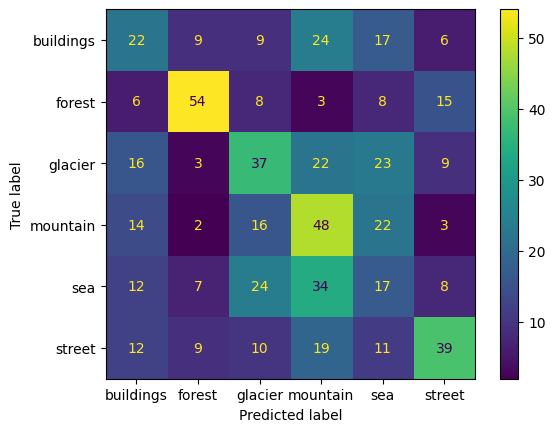

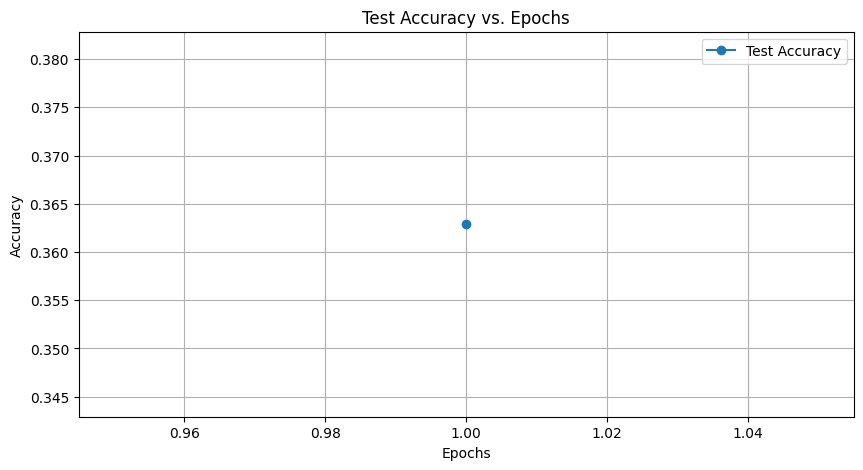

Total Training Time: 97.68222999572754 seconds
Total Testing Time: 0.787705659866333 seconds


In [3]:
import mxnet as mx
from mxnet import gluon, nd
from mxnet.gluon.data.vision import ImageFolderDataset, transforms
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import os
import time
import matplotlib.pyplot as plt

# Define data transforms
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Load data
train_data = gluon.data.DataLoader(
    ImageFolderDataset(root='intel_data/reduced_seg_train_new').transform_first(train_transform),
    batch_size=32, shuffle=False, num_workers=4)

test_data = gluon.data.DataLoader(
    ImageFolderDataset(root='intel_data/reduced_seg_test_new').transform_first(test_transform),
    batch_size=32, shuffle=False, num_workers=4)

# Extract class labels from subdirectory names
class_labels = [d.name for d in os.scandir('intel_data/reduced_seg_train_new') if d.is_dir()]

# Concatenate images and labels
train_images, train_labels = [], []
for data, label in train_data:
    train_images.append(data)
    train_labels.append(label)
train_images = nd.concat(*train_images, dim=0)
train_labels = nd.concat(*train_labels, dim=0)

test_images, test_labels = [], []
for data, label in test_data:
    test_images.append(data)
    test_labels.append(label)
test_images = nd.concat(*test_images, dim=0)
test_labels = nd.concat(*test_labels, dim=0)

# Flatten the images
train_images_flat = train_images.reshape((train_images.shape[0], -1))
test_images_flat = test_images.reshape((test_images.shape[0], -1))

# Train logistic regression model
lr_model = LogisticRegression(max_iter=1000)

# Record training time
start_train_time = time.time()
lr_model.fit(train_images_flat.asnumpy(), train_labels.asnumpy())
end_train_time = time.time()
total_train_time = end_train_time - start_train_time

# Predict using the logistic regression model
start_test_time = time.time()
test_predictions = lr_model.predict(test_images_flat.asnumpy())
end_test_time = time.time()
total_test_time = end_test_time - start_test_time

# Calculate accuracy
accuracy = accuracy_score(test_labels.asnumpy(), test_predictions)
print("Test Accuracy:", accuracy)

# Generate confusion matrix
mx_cm = confusion_matrix(test_labels.asnumpy(), test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=mx_cm, display_labels=class_labels)
disp.plot()

# Print classification report
report = classification_report(test_labels.asnumpy(), test_predictions, target_names=class_labels)
print("Classification Report:\n", report)

# Plotting training accuracy and test accuracy vs epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, 2), [accuracy], label='Test Accuracy', marker='o')
plt.title('Test Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Print total training and testing times
print(f"Total Training Time: {total_train_time} seconds")
print(f"Total Testing Time: {total_test_time} seconds")


TensorFlow

Found 2804 images belonging to 6 classes.
Found 598 images belonging to 6 classes.
Test Accuracy: 0.40468227424749165
Classification Report:
              precision    recall  f1-score   support

   buildings       0.30      0.22      0.25        87
      forest       0.67      0.57      0.62        94
     glacier       0.36      0.35      0.36       110
    mountain       0.40      0.57      0.47       105
         sea       0.24      0.28      0.26       102
      street       0.54      0.41      0.47       100

    accuracy                           0.40       598
   macro avg       0.42      0.40      0.40       598
weighted avg       0.42      0.40      0.40       598



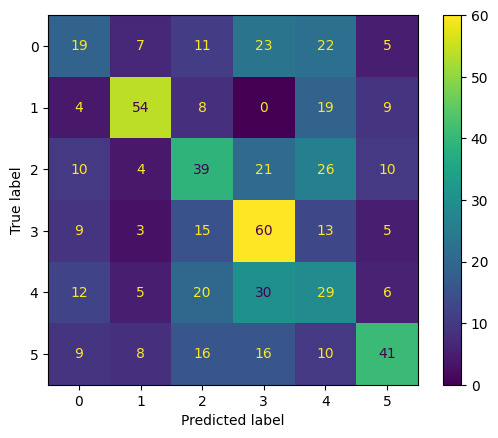

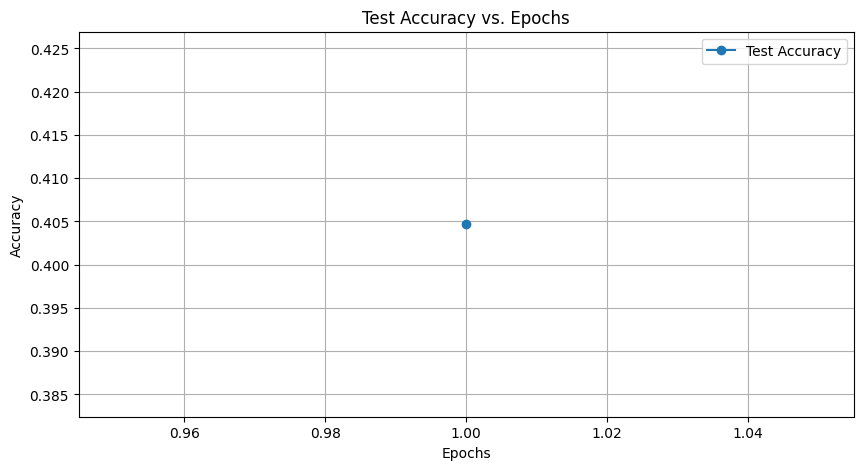

Total Training Time: 235.853125333786 seconds
Total Testing Time: 0.5869126319885254 seconds


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time

TRAIN_DATA_DIR = 'intel_data/reduced_seg_train_new'
TEST_DATA_DIR = 'intel_data/reduced_seg_test_new'

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical', 
    shuffle=False
)

class_labels = list(train_generator.class_indices.keys())

test_generator = test_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  
    shuffle=False
)

# Concatenate images and labels
train_images, train_labels = [], []
for i in range(len(train_generator)):
    batch_images, batch_labels = train_generator[i]
    train_images.append(batch_images)
    train_labels.append(batch_labels)
train_images = np.vstack(train_images)
train_labels = np.vstack(train_labels)

test_images, test_labels = [], []
for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator[i]
    test_images.append(batch_images)
    test_labels.append(batch_labels)
test_images = np.vstack(test_images)
test_labels = np.vstack(test_labels)

# Flatten the images
train_images_flat = train_images.reshape(train_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

# Training
lr_model = LogisticRegression(max_iter=1000)

start_train_time = time.time()
lr_model.fit(train_images_flat, np.argmax(train_labels, axis=1))
end_train_time = time.time()
total_train_time = end_train_time - start_train_time

# Testing
start_test_time = time.time()
test_predictions = lr_model.predict(test_images_flat)
end_test_time = time.time()
total_test_time = end_test_time - start_test_time

# Calculate accuracy
accuracy = accuracy_score(np.argmax(test_labels, axis=1), test_predictions)
print("Test Accuracy:", accuracy)

# Generate classification report
class_report = classification_report(np.argmax(test_labels, axis=1), test_predictions, target_names=class_labels)
print("Classification Report:")
print(class_report)

# Generate and plot confusion matrix
tf_cm = confusion_matrix(np.argmax(test_labels, axis=1), test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=tf_cm)
disp.plot()

# Plotting training accuracy and test accuracy vs epochs
plt.figure(figsize=(10, 5))
plt.plot([1], [accuracy], label='Test Accuracy', marker='o')
plt.title('Test Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Print total training and testing times
print(f"Total Training Time: {total_train_time} seconds")
print(f"Total Testing Time: {total_test_time} seconds")


### LeNet

MXNet

Epoch 1. Train Loss: 1.3539414405822754, Train Accuracy: 0.4709051724137931
   Test Loss: 1.2612163675458807, Test Accuracy: 0.5083612040133779
Epoch 2. Train Loss: 1.0759330809801475, Train Accuracy: 0.5854885057471264
   Test Loss: 1.0325604426233392, Test Accuracy: 0.6070234113712375
Epoch 3. Train Loss: 0.9337828392269968, Train Accuracy: 0.646551724137931
   Test Loss: 0.9138943474543723, Test Accuracy: 0.6588628762541806
Epoch 4. Train Loss: 0.8564005021391243, Train Accuracy: 0.6684626436781609
   Test Loss: 0.9057320246570989, Test Accuracy: 0.6655518394648829
Epoch 5. Train Loss: 0.758358900574432, Train Accuracy: 0.7147988505747126
   Test Loss: 0.9148785001353213, Test Accuracy: 0.6722408026755853
Epoch 6. Train Loss: 0.7034818040228438, Train Accuracy: 0.7453304597701149
   Test Loss: 0.9032970886481436, Test Accuracy: 0.6872909698996655
Epoch 7. Train Loss: 0.6588018402971071, Train Accuracy: 0.7478448275862069
   Test Loss: 0.925438160959043, Test Accuracy: 0.672240802675

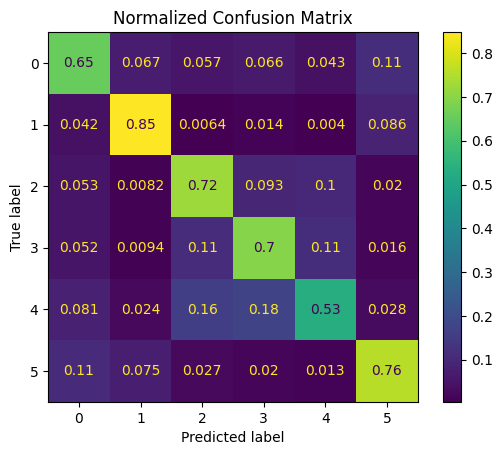

Total Training Time: 27.980843544006348 seconds
Total Evaluation Time: 3.064121961593628 seconds


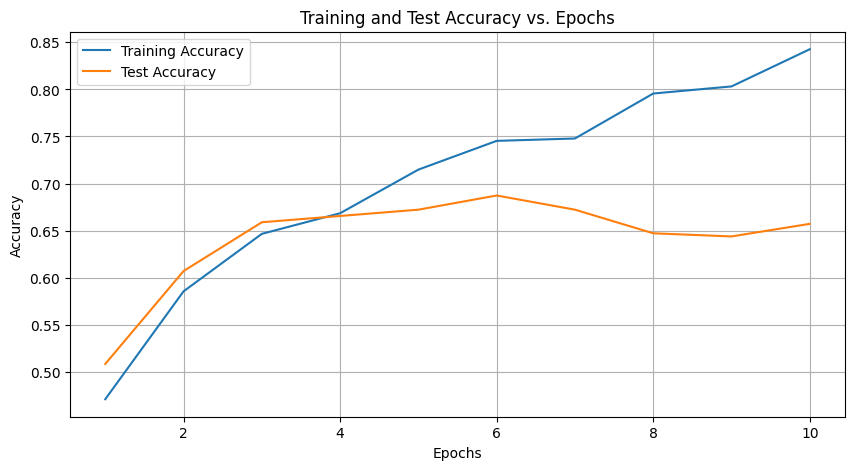

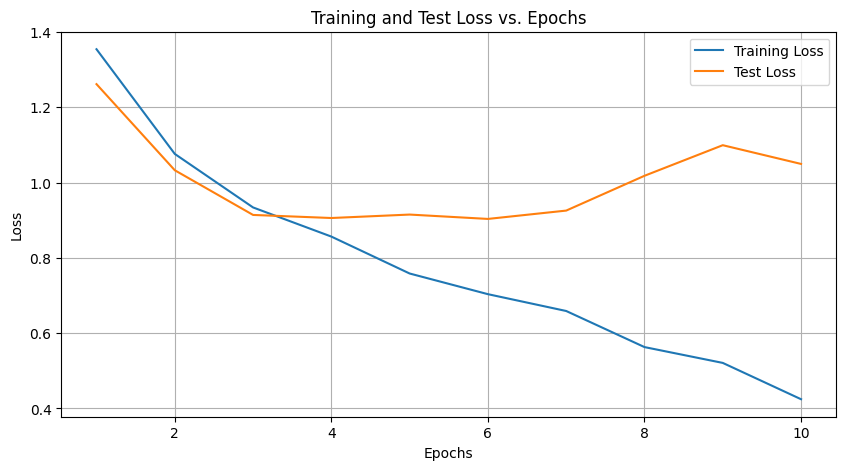

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.65      0.65      4349
           1       0.82      0.85      0.83      4510
           2       0.67      0.72      0.70      4766
           3       0.67      0.70      0.68      4982
           4       0.64      0.53      0.58      4502
           5       0.75      0.76      0.75      4731

    accuracy                           0.70     27840
   macro avg       0.70      0.70      0.70     27840
weighted avg       0.70      0.70      0.70     27840



In [7]:
import mxnet as mx
from mxnet.gluon.data.vision import ImageFolderDataset
from mxnet.gluon.data import DataLoader
from mxnet.gluon import nn
from mxnet import autograd
import time
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

TRAIN_DATA_DIR = 'intel_data/reduced_seg_train_new'
TEST_DATA_DIR = 'intel_data/reduced_seg_test_new'

train_transform = mx.gluon.data.vision.transforms.Compose([
    mx.gluon.data.vision.transforms.Resize(32),
    mx.gluon.data.vision.transforms.ToTensor(),
    mx.gluon.data.vision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = mx.gluon.data.vision.transforms.Compose([
    mx.gluon.data.vision.transforms.Resize(32),
    mx.gluon.data.vision.transforms.ToTensor(),
    mx.gluon.data.vision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load data
train_data = DataLoader(
    ImageFolderDataset(root=TRAIN_DATA_DIR).transform_first(train_transform),
    batch_size=32, shuffle=True, num_workers=4, last_batch='discard')

test_data = DataLoader(
    ImageFolderDataset(root=TEST_DATA_DIR).transform_first(test_transform),
    batch_size=32, shuffle=False, num_workers=4)

# LeNet architecture
class LeNet(mx.gluon.Block):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        with self.name_scope():
            self.conv1 = nn.Conv2D(channels=6, kernel_size=5, activation='relu')
            self.pool1 = nn.MaxPool2D(pool_size=2, strides=2)
            self.conv2 = nn.Conv2D(channels=16, kernel_size=5, activation='relu')
            self.pool2 = nn.MaxPool2D(pool_size=2, strides=2)
            self.flatten = nn.Flatten()
            self.dense1 = nn.Dense(120, activation='relu')
            self.dense2 = nn.Dense(84, activation='relu')
            self.dense3 = nn.Dense(num_classes)

    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

# Extract classes from the dataset
classes = set()
for _, label in train_data._dataset:
    classes.add(label)
num_classes = len(classes)

# Instantiate the model
model = LeNet(num_classes)
model.initialize(mx.init.Xavier())

loss_fn = mx.gluon.loss.SoftmaxCrossEntropyLoss()
optimizer = mx.gluon.Trainer(model.collect_params(), 'adam')

epochs = 10

total_training_time = 0
total_evaluation_time = 0

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Lists to store training accuracy, training loss, test accuracy, and test loss for each epoch
train_accuracy_history = []
train_loss_history = []
test_accuracy_history = []
test_loss_history = []

for epoch in range(epochs):
    start_time_training = time.time()
    # Training loop
    train_loss = 0.
    correct_preds_train = 0
    total_samples_train = 0
    for data, label in train_data:
        with autograd.record():
            output = model(data)
            loss = loss_fn(output, label)
        loss.backward()
        optimizer.step(data.shape[0])
        train_loss += loss.mean().asscalar()
        preds_train = mx.nd.argmax(output, axis=1).asnumpy()  
        label_train = label.asnumpy()  
        correct_preds_train += (preds_train == label_train).sum()  
        total_samples_train += data.shape[0]
        true_labels.extend(label_train)
        predicted_labels.extend(preds_train)
    
    # Compute training accuracy and average training loss
    train_accuracy = correct_preds_train / total_samples_train
    avg_train_loss = train_loss / len(train_data)
    train_accuracy_history.append(train_accuracy)
    train_loss_history.append(avg_train_loss)

    end_time_training = time.time()
    epoch_training_time = end_time_training - start_time_training
    total_training_time += epoch_training_time

    # Computing test loss and accuracy
    test_loss = 0.
    correct_preds_test = 0
    total_samples_test = 0
    start_time_evaluation = time.time()
    for data, label in test_data:
        output = model(data)
        loss = loss_fn(output, label)
        test_loss += loss.mean().asscalar()
        preds_test = mx.nd.argmax(output, axis=1).asnumpy()  
        label_test = label.asnumpy()  
        correct_preds_test += (preds_test == label_test).sum()  
        total_samples_test += data.shape[0]

    # Compute test accuracy and average test loss
    test_accuracy = correct_preds_test / total_samples_test
    avg_test_loss = test_loss / len(test_data)
    test_accuracy_history.append(test_accuracy)
    test_loss_history.append(avg_test_loss)

    # Update evaluation time for this epoch
    end_time_evaluation = time.time()
    evaluation_time_epoch = end_time_evaluation - start_time_evaluation
    total_evaluation_time += evaluation_time_epoch

    # Print results for this epoch
    print(f"Epoch {epoch + 1}. Train Loss: {avg_train_loss}, Train Accuracy: {train_accuracy}")
    print(f"   Test Loss: {avg_test_loss}, Test Accuracy: {test_accuracy}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Normalize confusion matrix
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Display normalized confusion matrix
disp = ConfusionMatrixDisplay(normalized_conf_matrix)
disp.plot()
plt.title('Normalized Confusion Matrix')
plt.show()

# Print total training and evaluation time
print(f"Total Training Time: {total_training_time} seconds")
print(f"Total Evaluation Time: {total_evaluation_time} seconds")

# Generate line graphs for training accuracy and test accuracy vs. epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracy_history, label='Training Accuracy')
plt.plot(range(1, epochs + 1), test_accuracy_history, label='Test Accuracy')
plt.title('Training and Test Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Generate line graphs for training loss and test loss vs. epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, epochs + 1), test_loss_history, label='Test Loss')
plt.title('Training and Test Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Generate and print classification report
class_report = classification_report(true_labels, predicted_labels, target_names=[str(i) for i in range(num_classes)])
print("Classification Report:")
print(class_report)


Tensorflow

Found 2246 images belonging to 6 classes.
Found 598 images belonging to 6 classes.


C:\Users\yashi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
C:\Users\yashi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1:
  Time taken: 5.6600377559661865 seconds
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.4509 - loss: 1.2928
  Train Loss: 1.286264419555664, Train Accuracy: 0.4599287509918213
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5927 - loss: 1.1457
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
  Test Loss: 1.4031527042388916, Test Accuracy: 0.46321070194244385
Epoch 2:
  Time taken: 2.583296537399292 seconds
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5129 - loss: 1.1902
  Train Loss: 1.2019195556640625, Train Accuracy: 0.5102404356002808
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4604 - loss: 1.3731
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
  Test Loss: 1.203759789466858, Test Accuracy: 0.5317725539207458
Epoch 3:
  Time taken: 2.570067882537842 seconds
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5659 - loss: 1.1300
  Train Loss: 1.1066110134124756, Train Accuracy: 0.5721282362937927
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5386 - l

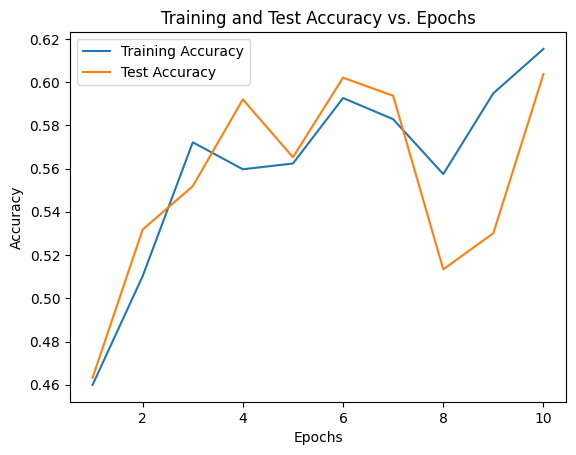

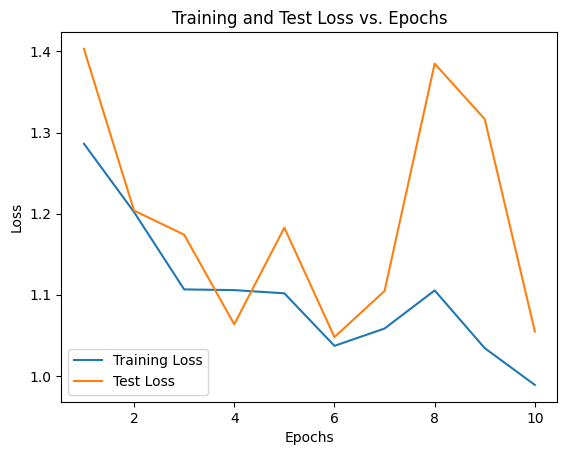

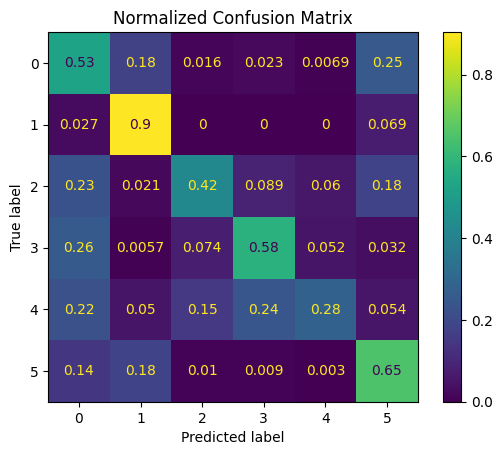

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.53      0.41       870
           1       0.67      0.90      0.77       940
           2       0.65      0.42      0.51      1100
           3       0.62      0.58      0.60      1050
           4       0.69      0.28      0.40      1020
           5       0.53      0.65      0.59      1000

    accuracy                           0.55      5980
   macro avg       0.58      0.56      0.55      5980
weighted avg       0.59      0.55      0.55      5980



In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

TRAIN_DATA_DIR = 'intel_data/reduced_seg_train_new'
TEST_DATA_DIR = 'intel_data/reduced_seg_test_new'

# Define data generators with augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# LeNet architecture
model = models.Sequential([
    layers.Conv2D(6, (5, 5), padding='same', activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (5, 5), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    layers.Dense(84, activation='relu'),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

epochs = 10
total_training_time = 0
total_evaluation_time = 0

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Lists to store training accuracy and loss
train_accuracy_list = []
train_loss_list = []
test_accuracy_list = []
test_loss_list = []

for epoch in range(epochs):
    start_time_epoch = time.time()
    # Train the model
    history = model.fit(train_generator, epochs=1, verbose=0)
    end_time_epoch = time.time()
    epoch_time = end_time_epoch - start_time_epoch
    total_training_time += epoch_time
    
    print(f"Epoch {epoch + 1}:")
    print(f"  Time taken: {epoch_time} seconds")

    # Calculate training accuracy and loss
    train_loss, train_accuracy = model.evaluate(train_generator)
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    print(f"  Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")
    
    # Evaluate the model on test data
    start_time_evaluation = time.time()
    test_loss, test_accuracy = model.evaluate(test_generator)
    end_time_evaluation = time.time()
    evaluation_time = end_time_evaluation - start_time_evaluation
    total_evaluation_time += evaluation_time

    # Predict using the model
    test_pred = model.predict(test_generator)
    true_labels.extend(test_generator.classes)
    predicted_labels.extend(np.argmax(test_pred, axis=1))
    
    # Store test accuracy and loss
    test_accuracy_list.append(test_accuracy)
    test_loss_list.append(test_loss)
    
    # Print results for this epoch
    print(f"  Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Print total training and evaluation time
print(f"Total Training Time: {total_training_time} seconds")
print(f"Total Evaluation Time: {total_evaluation_time} seconds")

# Plotting training accuracy and test accuracy vs. epochs
plt.plot(range(1, epochs + 1), train_accuracy_list, label='Training Accuracy')
plt.plot(range(1, epochs + 1), test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy vs. Epochs')
plt.legend()
plt.show()

# Plotting training loss and test loss vs. epochs
plt.plot(range(1, epochs + 1), train_loss_list, label='Training Loss')
plt.plot(range(1, epochs + 1), test_loss_list, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss vs. Epochs')
plt.legend()
plt.show()

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Normalize confusion matrix
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Display normalized confusion matrix
disp = ConfusionMatrixDisplay(normalized_conf_matrix)
disp.plot()
plt.title('Normalized Confusion Matrix')
plt.show()

# Generate and print classification report
class_report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(class_report)


In [5]:
from scipy import stats

# Test Accuracy data for MXNet and TensorFlow
mxnet_test_accuracy = [0.5084, 0.6070, 0.6589, 0.6656, 0.6722, 0.6873, 0.6722, 0.6472, 0.6438, 0.6572]
tensorflow_test_accuracy = [0.4632, 0.5318, 0.5518, 0.6037]

# Test Loss data for MXNet and TensorFlow
mxnet_test_loss = [1.2612, 1.0326, 0.9139, 0.9057, 0.9149, 0.9033, 0.9254, 1.0179, 1.0991, 1.0493]
tensorflow_test_loss = [1.4032, 1.2038, 1.1741, 1.0547]

# Perform two-sample t-tests for Test Accuracy and Test Loss
accuracy_t_stat, accuracy_p_value = stats.ttest_ind(mxnet_test_accuracy, tensorflow_test_accuracy)
loss_t_stat, loss_p_value = stats.ttest_ind(mxnet_test_loss, tensorflow_test_loss)

# Output the results
print("Two-Sample t-test Results:")
print("Test Accuracy:")
print("  t-statistic:", accuracy_t_stat)
print("  p-value:", accuracy_p_value)
if accuracy_p_value < 0.05:
    print("  Reject the null hypothesis. There is a significant difference in Test Accuracy between MXNet and TensorFlow.")
else:
    print("  Fail to reject the null hypothesis. There is no significant difference in Test Accuracy between MXNet and TensorFlow.")

print("\nTest Loss:")
print("  t-statistic:", loss_t_stat)
print("  p-value:", loss_p_value)
if loss_p_value < 0.05:
    print("  Reject the null hypothesis. There is a significant difference in Test Loss between MXNet and TensorFlow.")
else:
    print("  Fail to reject the null hypothesis. There is no significant difference in Test Loss between MXNet and TensorFlow.")


Two-Sample t-test Results:
Test Accuracy:
  t-statistic: 3.3044240657602235
  p-value: 0.006289000697068177
  Reject the null hypothesis. There is a significant difference in Test Accuracy between MXNet and TensorFlow.

Test Loss:
  t-statistic: -2.8278739432113515
  p-value: 0.015235723579729786
  Reject the null hypothesis. There is a significant difference in Test Loss between MXNet and TensorFlow.


### AlexNet

MXNet

Epoch 1. Train Loss: 1.7593724782439484, Train Accuracy: 0.30064655172413796
   Test Loss: 1.4394360247411226, Test Accuracy: 0.41471571906354515
Epoch 2. Train Loss: 1.3858551088420825, Train Accuracy: 0.44145114942528735
   Test Loss: 1.2008295623879683, Test Accuracy: 0.5100334448160535
Epoch 3. Train Loss: 1.285025612376202, Train Accuracy: 0.47270114942528735
   Test Loss: 1.1531873533600254, Test Accuracy: 0.5217391304347826


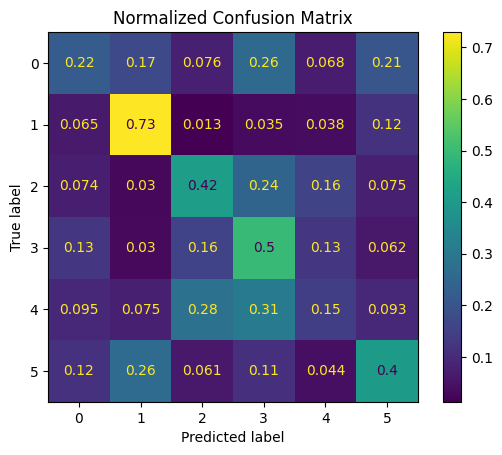

Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.22      0.25      1300
           1       0.56      0.73      0.63      1356
           2       0.42      0.42      0.42      1431
           3       0.36      0.50      0.42      1494
           4       0.24      0.15      0.18      1351
           5       0.43      0.40      0.42      1420

    accuracy                           0.40      8352
   macro avg       0.38      0.40      0.39      8352
weighted avg       0.39      0.40      0.39      8352

Total Training Time: 950.0584402084351 seconds
Total Evaluation Time: 85.70686721801758 seconds


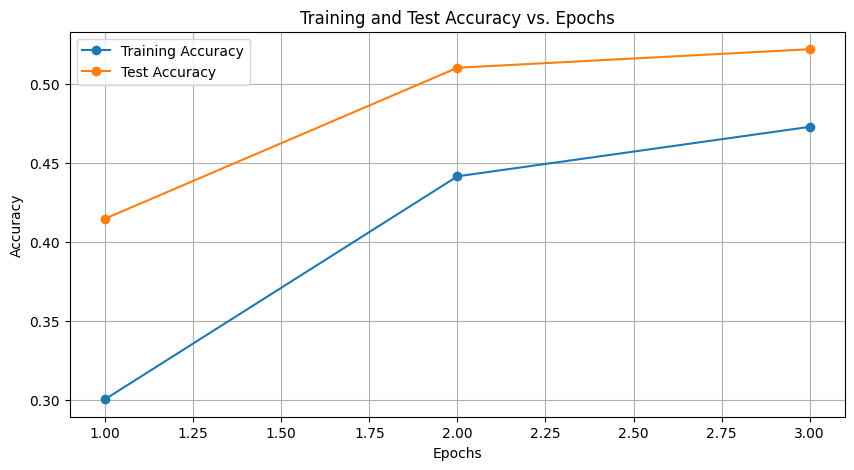

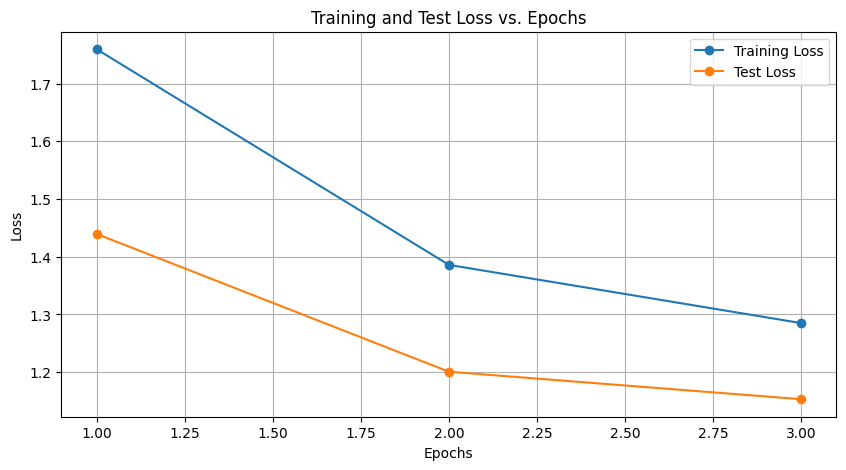

In [9]:
import mxnet as mx
from mxnet.gluon.data.vision import ImageFolderDataset
from mxnet.gluon.data import DataLoader
from mxnet.gluon import nn
from mxnet import autograd
import time
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

TRAIN_DATA_DIR = 'intel_data/reduced_seg_train_new'
TEST_DATA_DIR = 'intel_data/reduced_seg_test_new'

train_transform = mx.gluon.data.vision.transforms.Compose([
    mx.gluon.data.vision.transforms.Resize(224),
    mx.gluon.data.vision.transforms.ToTensor(),
    mx.gluon.data.vision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = mx.gluon.data.vision.transforms.Compose([
    mx.gluon.data.vision.transforms.Resize(224),
    mx.gluon.data.vision.transforms.ToTensor(),
    mx.gluon.data.vision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load data
train_data = DataLoader(
    ImageFolderDataset(root=TRAIN_DATA_DIR).transform_first(train_transform),
    batch_size=32, shuffle=True, num_workers=4, last_batch='discard')

test_data = DataLoader(
    ImageFolderDataset(root=TEST_DATA_DIR).transform_first(test_transform),
    batch_size=32, shuffle=False, num_workers=4)

# AlexNet architecture
class AlexNet(mx.gluon.Block):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        with self.name_scope():
            self.features = nn.Sequential()
            with self.features.name_scope():
                self.features.add(
                    nn.Conv2D(channels=96, kernel_size=11, strides=4, activation='relu'),
                    nn.MaxPool2D(pool_size=3, strides=2),
                    nn.Conv2D(channels=256, kernel_size=5, padding=2, activation='relu'),
                    nn.MaxPool2D(pool_size=3, strides=2),
                    nn.Conv2D(channels=384, kernel_size=3, padding=1, activation='relu'),
                    nn.Conv2D(channels=384, kernel_size=3, padding=1, activation='relu'),
                    nn.Conv2D(channels=256, kernel_size=3, padding=1, activation='relu'),
                    nn.MaxPool2D(pool_size=3, strides=2),
                )
            self.flatten = nn.Flatten()
            self.classifier = nn.Sequential()
            with self.classifier.name_scope():
                self.classifier.add(
                    nn.Dense(4096, activation='relu'),
                    nn.Dropout(0.5),
                    nn.Dense(4096, activation='relu'),
                    nn.Dropout(0.5),
                    nn.Dense(num_classes)
                )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

# Extract classes from the dataset
classes = set()
for _, label in train_data._dataset:
    classes.add(label)
num_classes = len(classes)

# Instantiate the model
model = AlexNet(num_classes)
model.initialize(mx.init.Xavier())

loss_fn = mx.gluon.loss.SoftmaxCrossEntropyLoss()
optimizer = mx.gluon.Trainer(model.collect_params(), 'adam')

epochs = 3

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Lists to store training accuracy, training loss, test accuracy, and test loss for each epoch
train_accuracy_history = []
train_loss_history = []
test_accuracy_history = []
test_loss_history = []

# Measure total training time and evaluation time
total_training_time = 0
total_evaluation_time = 0

for epoch in range(epochs):
    # Measure training time for this epoch
    start_time_training = time.time()

    # Training loop
    train_loss = 0.
    correct_preds_train = 0
    total_samples_train = 0
    for data, label in train_data:
        with autograd.record():
            output = model(data)
            loss = loss_fn(output, label)
        loss.backward()
        optimizer.step(data.shape[0])
        train_loss += loss.mean().asscalar()
        preds_train = mx.nd.argmax(output, axis=1).asnumpy()  
        label_train = label.asnumpy()  
        correct_preds_train += (preds_train == label_train).sum()  
        total_samples_train += data.shape[0]
        true_labels.extend(label_train)
        predicted_labels.extend(preds_train)
    
    # Compute training accuracy and average training loss
    train_accuracy = correct_preds_train / total_samples_train
    avg_train_loss = train_loss / len(train_data)
    train_accuracy_history.append(train_accuracy)
    train_loss_history.append(avg_train_loss)

    end_time_training = time.time()
    epoch_training_time = end_time_training - start_time_training
    total_training_time += epoch_training_time

    # Measure evaluation time for this epoch
    start_time_evaluation = time.time()

    # Computing test loss and accuracy
    test_loss = 0.
    correct_preds_test = 0
    total_samples_test = 0
    for data, label in test_data:
        output = model(data)
        loss = loss_fn(output, label)
        test_loss += loss.mean().asscalar()
        preds_test = mx.nd.argmax(output, axis=1).asnumpy()  
        label_test = label.asnumpy()  
        correct_preds_test += (preds_test == label_test).sum()  
        total_samples_test += data.shape[0]

    # Compute test accuracy and average test loss
    test_accuracy = correct_preds_test / total_samples_test
    avg_test_loss = test_loss / len(test_data)
    test_accuracy_history.append(test_accuracy)
    test_loss_history.append(avg_test_loss)

    # Update evaluation time for this epoch
    end_time_evaluation = time.time()
    epoch_evaluation_time = end_time_evaluation - start_time_evaluation
    total_evaluation_time += epoch_evaluation_time

    # Print results for this epoch
    print(f"Epoch {epoch + 1}. Train Loss: {avg_train_loss}, Train Accuracy: {train_accuracy}")
    print(f"   Test Loss: {avg_test_loss}, Test Accuracy: {test_accuracy}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Normalize confusion matrix
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Display normalized confusion matrix
disp = ConfusionMatrixDisplay(normalized_conf_matrix)
disp.plot()
plt.title('Normalized Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(class_report)

# Print total training and evaluation time
print(f"Total Training Time: {total_training_time} seconds")
print(f"Total Evaluation Time: {total_evaluation_time} seconds")

# Generate line graphs for training accuracy and test accuracy vs. epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracy_history, label='Training Accuracy', marker='o')
plt.plot(range(1, epochs + 1), test_accuracy_history, label='Test Accuracy', marker='o')
plt.title('Training and Test Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Generate line graphs for training loss and test loss vs. epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_loss_history, label='Training Loss', marker='o')
plt.plot(range(1, epochs + 1), test_loss_history, label='Test Loss', marker='o')
plt.title('Training and Test Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Tensorflow

Found 2246 images belonging to 6 classes.
Found 598 images belonging to 6 classes.
Epoch 1:
  Time taken: 59.96314191818237 seconds
71/71 ━━━━━━━━━━━━━━━━━━━━ 36s 490ms/step - accuracy: 0.1655 - loss: 1.7931
  Train Loss: 1.792205572128296, Train Accuracy: 0.17141585052013397
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.0297 - loss: 1.8020
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step
  Test Loss: 1.793333888053894, Test Accuracy: 0.16889631748199463
Epoch 2:
  Time taken: 63.100207567214966 seconds
71/71 ━━━━━━━━━━━━━━━━━━━━ 34s 476ms/step - accuracy: 0.3259 - loss: 1.6096
  Train Loss: 1.602066159248352, Train Accuracy: 0.3245770335197449
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.3473 - loss: 1.5674
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step
  Test Loss: 1.5780562162399292, Test Accuracy: 0.3411371111869812
Epoch 3:
  Time taken: 124.5035285949707 seconds
71/71 ━━━━━━━━━━━━━━━━━━━━ 60s 845ms/step - accuracy: 0.4721 - loss: 1.2909
  Train Loss: 1.300162434577942, Train

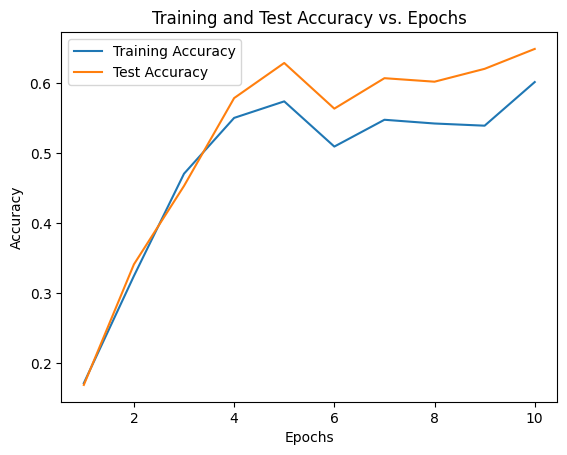

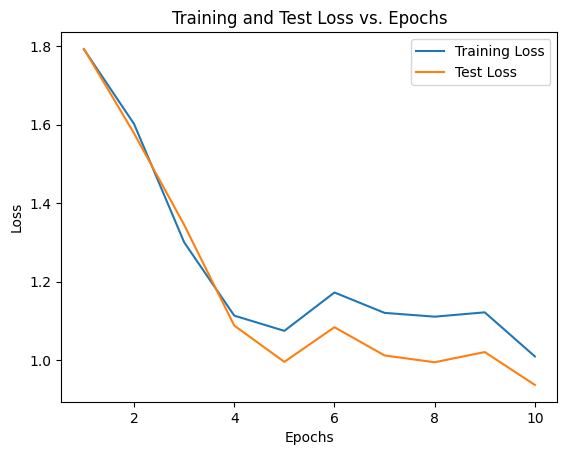

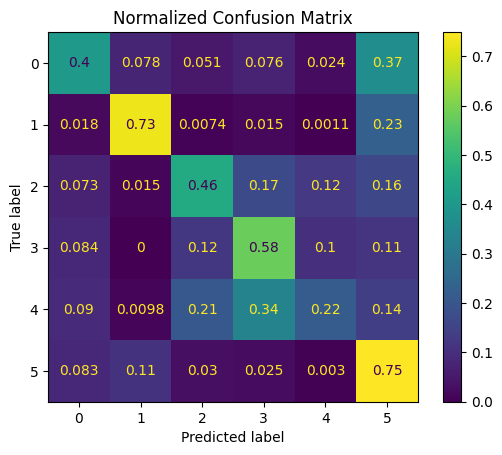

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

TRAIN_DATA_DIR = 'intel_data/reduced_seg_train_new'
TEST_DATA_DIR = 'intel_data/reduced_seg_test_new'
# Define data generators with augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(227, 227),  # Adjusted target size for AlexNet
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(227, 227),  # Adjusted target size for AlexNet
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# AlexNet architecture
model = models.Sequential([
    layers.Conv2D(96, (11, 11), strides=(4,4), padding='valid', activation='relu', input_shape=(227, 227, 3)),
    layers.MaxPooling2D((3, 3), strides=(2,2)),
    layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
    layers.MaxPooling2D((3, 3), strides=(2,2)),
    layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((3, 3), strides=(2,2)),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

epochs = 10
total_training_time = 0
total_evaluation_time = 0

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Lists to store training accuracy and loss
train_accuracy_list = []
train_loss_list = []
test_accuracy_list = []
test_loss_list = []

for epoch in range(epochs):
    start_time_epoch = time.time()
    # Train the model
    history = model.fit(train_generator, epochs=1, verbose=0)
    end_time_epoch = time.time()
    epoch_time = end_time_epoch - start_time_epoch
    total_training_time += epoch_time

    print(f"Epoch {epoch + 1}:")
    print(f"  Time taken: {epoch_time} seconds")

    # Calculate training accuracy and loss
    train_loss, train_accuracy = model.evaluate(train_generator)
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    print(f"  Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")

    # Evaluate the model on test data
    start_time_evaluation = time.time()
    test_loss, test_accuracy = model.evaluate(test_generator)
    end_time_evaluation = time.time()
    evaluation_time = end_time_evaluation - start_time_evaluation
    total_evaluation_time += evaluation_time

    # Predict using the model
    test_pred = model.predict(test_generator)
    true_labels.extend(test_generator.classes)
    predicted_labels.extend(tf.argmax(test_pred, axis=1))

    # Store test accuracy and loss
    test_accuracy_list.append(test_accuracy)
    test_loss_list.append(test_loss)

    # Print results for this epoch
    print(f"  Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Print total training and evaluation time
print(f"Total Training Time: {total_training_time} seconds")
print(f"Total Evaluation Time: {total_evaluation_time} seconds")

# Plotting training accuracy and test accuracy vs. epochs
plt.plot(range(1, epochs + 1), train_accuracy_list, label='Training Accuracy')
plt.plot(range(1, epochs + 1), test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy vs. Epochs')
plt.legend()
plt.show()

# Plotting training loss and test loss vs. epochs
plt.plot(range(1, epochs + 1), train_loss_list, label='Training Loss')
plt.plot(range(1, epochs + 1), test_loss_list, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss vs. Epochs')
plt.legend()
plt.show()

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Normalize confusion matrix
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Display normalized confusion matrix
disp = ConfusionMatrixDisplay(normalized_conf_matrix)
disp.plot()
plt.title('Normalized Confusion Matrix')
plt.show()


In [13]:
from sklearn.metrics import classification_report, precision_score, recall_score

# Calculate precision and recall
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

# Generate classification report
class_report = classification_report(true_labels, predicted_labels)
print("Classification Report:\n", class_report)


Precision: 0.5306339784335955
Recall: 0.5223525671768519
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.40      0.44       870
           1       0.77      0.73      0.75       940
           2       0.54      0.46      0.50      1100
           3       0.49      0.58      0.53      1050
           4       0.45      0.22      0.29      1020
           5       0.43      0.75      0.55      1000

    accuracy                           0.52      5980
   macro avg       0.53      0.52      0.51      5980
weighted avg       0.53      0.52      0.51      5980



In [6]:
from scipy import stats

# Test Accuracy data for MXNet and TensorFlow
mxnet_test_accuracy = [0.4147, 0.5100, 0.5217]
tensorflow_test_accuracy = [0.1689, 0.3411, 0.4532, 0.6488]

# Test Loss data for MXNet and TensorFlow
mxnet_test_loss = [1.4394, 1.2008, 1.1532]
tensorflow_test_loss = [1.7933, 1.5781, 1.3446, 0.9364]

# Perform two-sample t-tests for Test Accuracy and Test Loss
accuracy_t_stat, accuracy_p_value = stats.ttest_ind(mxnet_test_accuracy, tensorflow_test_accuracy)
loss_t_stat, loss_p_value = stats.ttest_ind(mxnet_test_loss, tensorflow_test_loss)

# Output the results
print("Two-Sample t-test Results:")
print("Test Accuracy:")
print("  t-statistic:", accuracy_t_stat)
print("  p-value:", accuracy_p_value)
if accuracy_p_value < 0.05:
    print("  Reject the null hypothesis. There is a significant difference in Test Accuracy between MXNet and TensorFlow.")
else:
    print("  Fail to reject the null hypothesis. There is no significant difference in Test Accuracy between MXNet and TensorFlow.")

print("\nTest Loss:")
print("  t-statistic:", loss_t_stat)
print("  p-value:", loss_p_value)
if loss_p_value < 0.05:
    print("  Reject the null hypothesis. There is a significant difference in Test Loss between MXNet and TensorFlow.")
else:
    print("  Fail to reject the null hypothesis. There is no significant difference in Test Loss between MXNet and TensorFlow.")


Two-Sample t-test Results:
Test Accuracy:
  t-statistic: 0.6463975395026897
  p-value: 0.5465168850414275
  Fail to reject the null hypothesis. There is no significant difference in Test Accuracy between MXNet and TensorFlow.

Test Loss:
  t-statistic: -0.6481508984430353
  p-value: 0.5454712120334062
  Fail to reject the null hypothesis. There is no significant difference in Test Loss between MXNet and TensorFlow.
